In this notebook, one slice of the article's data is re-processed and we illustrate how one can mitigate inflated FA values by excluding voxels with high volume free water volume.

Let's first import the relevant modules:

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Import Dipy's procedures to process diffusion tensor
import dipy.reconst.dti as dti

# Import Dipy's functions that load and read CENIR data
from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib

# Import Dipy's brain segmentation function
from dipy.segment.mask import median_otsu

# Importing procedures to fit the free water elimination DTI model
from functions import nls_fit_tensor

Downloading data (note 1.7 Gb of data will be downloaded)...

In [2]:
# Download data using dipy's function fetch_cenir_multib
fetch_cenir_multib(with_raw=False)

# Select the b-values to read
bvals = [200, 400, 1000, 2000]

# Read data using dipy's function read_cenir_multib
img, gtab = read_cenir_multib(bvals)

# Read matrix containing data from img object
data = img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 


Estimate a brain mask...

In [3]:
maskdata, mask = median_otsu(data, 4, 2, False, vol_idx=[0, 1], dilate=1)

To speed up the processing time of this notebook, some lines of code are added so that only the plotted axial slice is processed.

In [4]:
# Define ROI for a selected axial slice
axial_slice = 40
mask_roi = np.zeros(data.shape[:-1], dtype=bool)
mask_roi[:, :, axial_slice] = mask[:, :, axial_slice]

Fitting the free water DTI model...

In [5]:
t0 = time.time()
fw_params = nls_fit_tensor(gtab, data, mask_roi)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 28.899000 seconds to run


Compute tensor statistic from the fitted parameters...

In [6]:
# Extract tissue's diffusion tensor eigenvalues
evals = fw_params[..., :3]

# Extract free water volume fraction estimates
F = fw_params[..., 12]

# Compute the tissue's diffusion tensor fractional anisotropy
# using function fractional_anisotropy of Dipy's module dti
FA = dti.fractional_anisotropy(evals)

# Compute the tissue's diffusion tensor mean diffusivity
# using function mean_diffusivity of Dipy's module dti
MD = dti.mean_diffusivity(evals)

Compute standard DTI for comparison...

In [7]:
# Define the standard DTI model using Dipy's modules
# given the acquisition parameters that were read
dtimodel = dti.TensorModel(gtab)

# Fit DTI model in voxel pointed by the brain ROI
dtifit = dtimodel.fit(data, mask=mask_roi)

# Extract standard FA and MD from the DTI fitted parameters
dti_FA = dtifit.fa
dti_MD = dtifit.md

Plot data for a axial slice of the data ...

C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


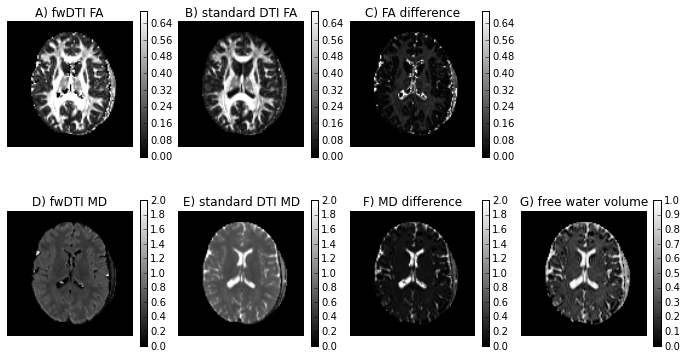

In [8]:
fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.1)

# Plot fwDTI FA
im = ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[0].set_title('A) fwDTI FA')
fig1.colorbar(im, ax=ax.flat[0])

# Plot DTI FA
im = ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[1].set_title('B) standard DTI FA')
fig1.colorbar(im, ax=ax.flat[1])

# Plot DTI difference
FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
im = ax.flat[2].imshow(FAdiff.T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[2].set_title('C) FA difference')
fig1.colorbar(im, ax=ax.flat[2])

# Turn off the unnecessary panel
ax.flat[3].axis('off')

# Plot fwDTI MD
im =ax.flat[4].imshow(MD[:, :, axial_slice].T * 1000,
                      origin='lower', cmap='gray', vmin=0, vmax=2)
ax.flat[4].set_title('D) fwDTI MD')
fig1.colorbar(im, ax=ax.flat[4])

# Plot DTI MD
im = ax.flat[5].imshow(dti_MD[:, :, axial_slice].T * 1000,
                       origin='lower', cmap='gray', vmin=0, vmax=2)
ax.flat[5].set_title('E) standard DTI MD')
fig1.colorbar(im, ax=ax.flat[5])

# Plot MD difference
MDdiff = abs(MD[:, :, axial_slice] - dti_MD[:, :, axial_slice]) * 1000
im =ax.flat[6].imshow(MDdiff.T, origin='lower',
                      cmap='gray', vmin=0, vmax=2)
ax.flat[6].set_title('F) MD difference')
fig1.colorbar(im, ax=ax.flat[6])

# Plot free water volume fraction
im = ax.flat[7].imshow(F[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=1)
ax.flat[7].set_title('G) free water volume')
fig1.colorbar(im, ax=ax.flat[7])

plt.show()
fig1.savefig('In_vivo_free_water_DTI_and_standard_DTI_measures.png', bbox_inches='tight')

As mentioned in the main article unexpected high amplitudes of FA are however observed in the periventricular gray mater. Above we mitigate this inflated values of FA by removing in our analysis all voxels with measured free water volume fraction of 0.7.

In [9]:
FA[F > 0.7] = 0
dti_FA[F > 0.7] = 0

Above we reproduce the plots of the in vivo FA from the two DTI fits and where we can see that the inflated FA values were practically removed:

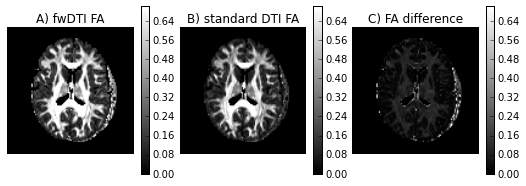

In [10]:
fig2, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.1)

# Plot fwDTI FA
im = ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[0].set_title('A) fwDTI FA')
fig2.colorbar(im, ax=ax.flat[0])

# Plot DTI FA
im = ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[1].set_title('B) standard DTI FA')
fig2.colorbar(im, ax=ax.flat[1])

# Plot DTI difference
FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
im = ax.flat[2].imshow(FAdiff.T, origin='lower',
                       cmap='gray', vmin=0, vmax=0.7)
ax.flat[2].set_title('C) FA difference')
fig2.colorbar(im, ax=ax.flat[2])

plt.show()
fig2.savefig('In_vivo_free_water_DTI_and_standard_DTI_corrected.png', bbox_inches='tight')